In [1]:
#pip install matplotlib
#%pip install plotly
#%pip install -U kaleido
#%pip install nbformat
#%pip install notebook ipywidgets nbformat


## Imports & Configuration

In [2]:
# --- Setup: imports ---
import os
import math
import importlib.util
from pathlib import Path
from typing import Optional, Union, Tuple
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Ensure inline plotting
%matplotlib inline

# --- Global Configuration ---
READ_DIR = Path(r"P:\2025\NOGAL CANYON\01_CAPTURE\05_PHOTOGRAMMETRY")
OUTPUT_DIR = Path(r"P:\2025\NOGAL CANYON\02_PRODUCTION\01_PIX4D")
IMAGE_EXTENSION = ".jpg"
GEOTAG_PATTERN = "*geotags.csv"
REPORT_SUBDIR = "REPORT_GEOTAGGING_METRICS"
FALLBACK_DIR = Path(r"C:\temp")


## Functions

In [3]:
def count_files_by_extension(directory: Path, extension: str) -> int:
    return sum(1 for _, _, files in os.walk(directory) for file in files if file.lower().endswith(extension.lower()))

def load_geotag_csvs(base_path: Path, pattern: str = GEOTAG_PATTERN) -> Tuple[pd.DataFrame, int, int]:
    files = sorted(base_path.rglob(pattern))
    if not files:
        raise FileNotFoundError(f"No files matching '{pattern}' found in: {base_path.resolve()}")

    frames = []
    for file in files:
        df = pd.read_csv(file, sep=None, engine="python")
        df.columns = df.columns.str.strip()
        df["source_name"] = file.name
        df["source_parent"] = file.parent.name
        frames.append(df)

    combined_df = pd.concat(frames, ignore_index=True)
    return combined_df, len(files), len(combined_df)

def prepare_output_dir(output_base: Path, source_base: Path) -> Tuple[Path, Path]:
    final_dir = (output_base / REPORT_SUBDIR) if output_base.exists() else FALLBACK_DIR / REPORT_SUBDIR
    final_dir.mkdir(parents=True, exist_ok=True)

    info_path = final_dir / "report.txt"
    with open(info_path, "w", encoding="utf-8") as f:
        f.write(
            f"Source base folder: {source_base.resolve()}\n"
            f"Folder name:        {source_base.name}\n"
            f"Prepared on:        {datetime.now().isoformat(timespec='seconds')}\n\n"
        )

    return final_dir, info_path

def save_combined_csv(df: pd.DataFrame, out_dir: Union[str, Path], filename: str = "combined_geotags.csv") -> Path:
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / filename
    df.to_csv(out_path, index=False)
    print(f"✅ CSV saved to: {out_path.resolve()}")
    return out_path


def summarize_accuracy_metrics(df: pd.DataFrame):
    horiz_col = "accuracy horizontal [meter]"
    vert_col = "accuracy vertical [meter]"

    df[horiz_col] = pd.to_numeric(df[horiz_col], errors='coerce')
    df[vert_col] = pd.to_numeric(df[vert_col], errors='coerce')

    summary = pd.DataFrame({
        horiz_col: [df[horiz_col].min(), df[horiz_col].max(), df[horiz_col].mean(), df[horiz_col].std()],
        vert_col: [df[vert_col].min(), df[vert_col].max(), df[vert_col].mean(), df[vert_col].std()]
    }, index=["min", "max", "mean", "std"]).T

    top10_horiz = df.sort_values(by=horiz_col, ascending=False).head(10)[['source_name', horiz_col]]
    top10_vert = df.sort_values(by=vert_col, ascending=False).head(10)[['source_name', vert_col]]

    return summary, top10_horiz, top10_vert

def plot_accuracy_vs_index(df: pd.DataFrame, output_dir: Path, filename_prefix: str = "accuracy_vs_index"):
    horiz_col = "accuracy horizontal [meter]"
    vert_col = "accuracy vertical [meter]"

    acc_h = pd.to_numeric(df[horiz_col], errors="coerce")
    acc_v = pd.to_numeric(df[vert_col], errors="coerce")
    valid_mask = acc_h.notna() | acc_v.notna()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(df.index[valid_mask], acc_h[valid_mask], label=horiz_col, alpha=0.7)
    ax.scatter(df.index[valid_mask], acc_v[valid_mask], label=vert_col, alpha=0.7)
    ax.set_xlabel("Row Index")
    ax.set_ylabel("Accuracy [meter]")
    ax.set_title("UAS Accuracy vs Row Index")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    output_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_dir / f"{filename_prefix}.png", dpi=150)
    print(f"✅ Accuracy plot saved to: {(output_dir / f'{filename_prefix}.png').resolve()}")

def plot_geotag_locations_zoomed(df: pd.DataFrame, output_dir: Path, filename_prefix: str = "geo_map"):
    lat_col = 'latitude [decimal degrees]'
    lon_col = 'longitude [decimal degrees]'

    df[lat_col] = pd.to_numeric(df[lat_col], errors='coerce')
    df[lon_col] = pd.to_numeric(df[lon_col], errors='coerce')
    df_valid = df.dropna(subset=[lat_col, lon_col])

    if df_valid.empty:
        print("⚠️ No valid coordinates to plot.")
        return

    lat_min, lat_max = df_valid[lat_col].min(), df_valid[lat_col].max()
    lon_min, lon_max = df_valid[lon_col].min(), df_valid[lon_col].max()
    center_lat = (lat_min + lat_max) / 2.0
    center_lon = (lon_min + lon_max) / 2.0
    max_range = max(lat_max - lat_min, lon_max - lon_min)

    zoom = 15 if max_range < 0.01 else 12 if max_range < 0.1 else 10 if max_range < 1 else 8 if max_range < 10 else 5

    fig = px.scatter_mapbox(
        df_valid,
        lat=lat_col,
        lon=lon_col,
        hover_name='source_name' if 'source_name' in df_valid.columns else None,
        title="Geotag Locations Map",
        height=600
    )
    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_center={"lat": center_lat, "lon": center_lon},
        mapbox_zoom=zoom,
        margin={"r": 0, "t": 40, "l": 0, "b": 0}
    )
    fig.show()

    output_dir.mkdir(parents=True, exist_ok=True)
    fig.write_image(output_dir / f"{filename_prefix}.png")
    fig.write_html(output_dir / f"{filename_prefix}.html")
    print(f"✅ Geotag map saved to: {(output_dir / f'{filename_prefix}.png').resolve()} and HTML")


📸 Total '.jpg' files found: 2961
✅ Loaded 8 CSV files with 2,959 rows
✅ CSV saved to: \\Bt95k74\Projects\2025\NOGAL CANYON\02_PRODUCTION\01_PIX4D\REPORT_GEOTAGGING_METRICS\combined_geotags.csv
📊 Summary Table:
                              min   max   mean    std
accuracy horizontal [meter]  0.02  0.32  0.025  0.009
accuracy vertical [meter]    0.03  0.44  0.050  0.021

Top 10 Horizontal Accuracy:
                          source_name  accuracy horizontal [meter]
1995  250904_Nogal_RGB_5b geotags.csv                         0.32
1444  250904_Nogal_RGB_4b geotags.csv                         0.07
1445  250904_Nogal_RGB_4b geotags.csv                         0.07
760   250904_Nogal_RGB_4a geotags.csv                         0.07
1443  250904_Nogal_RGB_4b geotags.csv                         0.07
1405  250904_Nogal_RGB_4b geotags.csv                         0.06
1321  250904_Nogal_RGB_4a geotags.csv                         0.06
1376  250904_Nogal_RGB_4a geotags.csv                         0

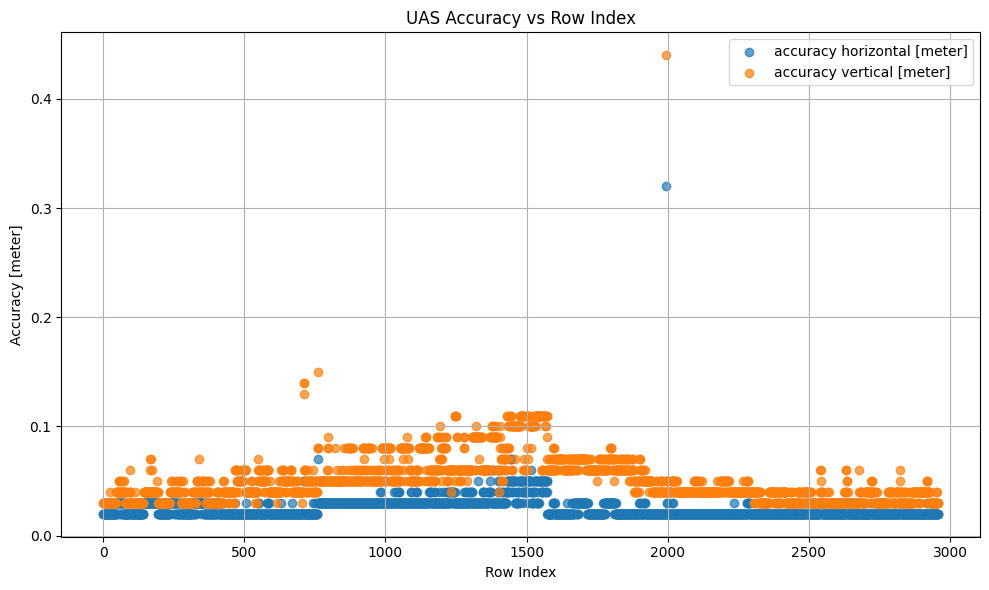

✅ Accuracy plot saved to: \\Bt95k74\Projects\2025\NOGAL CANYON\02_PRODUCTION\01_PIX4D\REPORT_GEOTAGGING_METRICS\accuracy_vs_index.png


C:\Users\USFJ139860\AppData\Local\Temp\ipykernel_35108\2096005404.py:103: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


✅ Geotag map saved to: \\Bt95k74\Projects\2025\NOGAL CANYON\02_PRODUCTION\01_PIX4D\REPORT_GEOTAGGING_METRICS\geo_map.png and HTML


In [4]:
# Step 1: Count image files
total_images = count_files_by_extension(READ_DIR, IMAGE_EXTENSION)
print(f"📸 Total '{IMAGE_EXTENSION}' files found: {total_images}")

# Step 2: Load geotags
df, num_csvs, total_rows = load_geotag_csvs(READ_DIR)
print(f"✅ Loaded {num_csvs} CSV files with {total_rows:,} rows")

# Step 3: Prepare output directory
final_dir, report_path = prepare_output_dir(OUTPUT_DIR, READ_DIR)

# Step 4: Save combined CSV
csv_path = save_combined_csv(df, final_dir)

# Step 5: Summarize accuracy
summary, top10_horiz, top10_vert = summarize_accuracy_metrics(df)
print("📊 Summary Table:")
print(summary.round(3))
print("\nTop 10 Horizontal Accuracy:")
print(top10_horiz)
print("\nTop 10 Vertical Accuracy:")
print(top10_vert)

# Step 6: Plot accuracy
plot_accuracy_vs_index(df, output_dir=final_dir)

# Step 7: Plot geotag map
plot_geotag_locations_zoomed(df, output_dir=final_dir)

# Step 8: Append summary to report
with open(report_path, "a", encoding="utf-8") as f:
    f.write(f"\nTotal '{IMAGE_EXTENSION}' files found: {total_images}\n")
    f.write(f"Loaded {num_csvs} CSV files\n")
    f.write(f"Total rows: {total_rows:,}\n")
    f.write(f"CSV saved to: {csv_path.resolve()}\n\n")
    f.write("Summary Table:\n")
    f.write(summary.round(3).to_string())
    f.write("\n\nTop 10 Horizontal Accuracy:\n")
    f.write(top10_horiz.to_string(index=True))
    f.write("\n\nTop 10 Vertical Accuracy:\n")
    f.write(top10_vert.to_string(index=True))
